In [1]:
%matplotlib inline
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import random
import warnings

import sklearn.tree
import sklearn.ensemble

from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import sys
sys.path.append('../dev')

from ml_plot import plot_validation_curve
from ml_plot import PredictCV, my_plot_learning_curve
from ml_plot import plot_prediction_curve
from ml_plot import get_dataset, eval_predictions

# Configuration

In [2]:
# PROJECT = 'nova'
# PROJECT = 'swift'
# PROJECT = 'cinder'
PROJECT = 'heat'
# PROJECT = 'glance'

# IMPORTANCE = 'crit'
# IMPORTANCE = 'high+'
IMPORTANCE = 'med+'
# IMPORTANCE = 'low+'

# SIZE = 100
#SIZE = 250
# SIZE = 0.1
SIZE = 0.5

SCORING = 'f1'         # (precision * recall) / (precision + recall)
# SCORING = 'accuracy'   # (TP + TN) / all values
# SCORING = 'precision'  # TP / (TP + FP)
# SCORING = 'recall'     # TP / (TP + FN)
# SCORING = 'average_precision'
# SCORING = 'roc_auc'

JOBS = 4

VERBOSE = 0

#warnings.simplefilter("ignore", UndefinedMetricWarning)
warnings.filterwarnings('ignore', 'F-score is ill-defined')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

# Load Data

In [3]:
%%capture
Y, X = get_dataset(PROJECT, IMPORTANCE)

### Select Split Strategy

In [4]:
#cv = PredictCV(len(Y), history=500, future=300, n_iter=10)
cv = PredictCV(len(Y), history=500, future=300, n_iter=100)

# AdaBoost  Classifier

In [5]:
estimator = sklearn.ensemble.AdaBoostClassifier()
param_grid = {'learning_rate': [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0],
              'n_estimators': [15, 25, 50],
               'algorithm': ['SAMME', 'SAMME.R'] }

In [6]:
grid = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=SCORING,
                    n_jobs=JOBS, pre_dispatch=2*JOBS, verbose=VERBOSE)
# grid.fit(X_train, Y_train)
grid.fit(X, Y)
print 'best_score: ', grid.best_score_
clf = grid.best_estimator_
grid.best_estimator_

best_score:  0.451378043598


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=2.0, n_estimators=25, random_state=None)

### Validation Curves

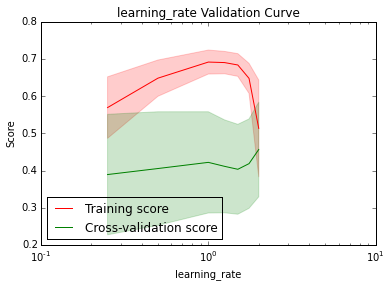

Best score of 0.456861109473 when setting learning_rate to 2.0


In [7]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          X, Y,
                          "learning_rate", [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0],
                          "learning_rate Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS)
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

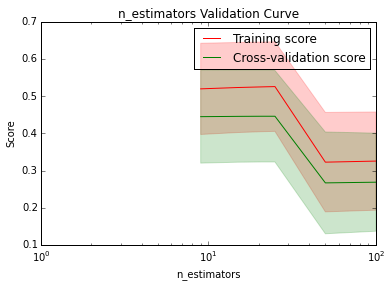

Best score of 0.446226772698 when setting n_estimators to 21


In [8]:
best_score, param_val, param_name = \
    plot_validation_curve(clf,
                          X, Y,
                          "n_estimators", [9, 15, 21, 25, 50, 100],
                          "n_estimators Validation Curve",
                          cv=cv, scoring=SCORING, n_jobs=JOBS)
print 'Best score of', best_score, 'when setting', param_name, 'to',  param_val

### Learning Curve

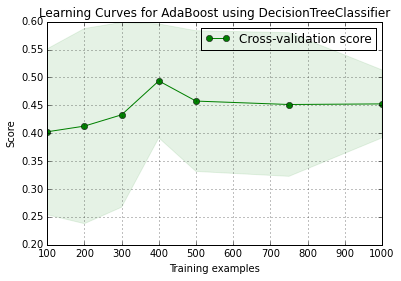

In [9]:
title = "Learning Curves for AdaBoost using DecisionTreeClassifier"
my_plot_learning_curve(clf, title, X, Y,
                           n_jobs=JOBS, future=500,
                           history_sizes=[100, 200, 300, 400, 500, 750, 1000],
                           n_iter=100)
plt.show()

### Prediction Curve

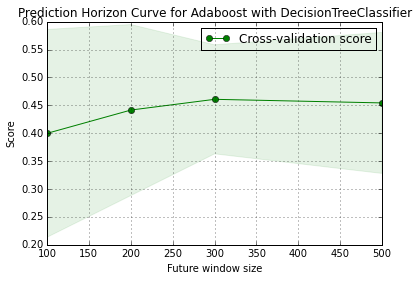

In [10]:
title = "Prediction Horizon Curve for Adaboost with DecisionTreeClassifier"
plot_prediction_curve(clf, title, X, Y,
                           n_jobs=JOBS, history=500,
                           future_sizes=[100, 200, 300, 500], n_iter=100)
plt.show()

In [11]:
AB_results = eval_predictions(clf, X, Y, history_sizes=[400, 500, 1000], future_sizes=[100, 300, 400, 500], n_iter=100)

** Predictions for hist=400 future=100 **

F1:        0.43  +/- 0.17
Accuracy:  0.71  +/- 0.10
Precision: 0.45  +/- 0.19
Recall:    0.45  +/- 0.23

Aggregate Confusion Matrix - 100 iterations
[[5814 1422]
 [1434 1330]]


** Predictions for hist=400 future=300 **

F1:        0.46  +/- 0.11
Accuracy:  0.72  +/- 0.08
Precision: 0.47  +/- 0.10
Recall:    0.49  +/- 0.17

Aggregate Confusion Matrix - 100 iterations
[[17592  4441]
 [ 3853  4114]]


** Predictions for hist=400 future=400 **

F1:        0.47  +/- 0.10
Accuracy:  0.72  +/- 0.07
Precision: 0.45  +/- 0.09
Recall:    0.51  +/- 0.14

Aggregate Confusion Matrix - 100 iterations
[[23083  6359]
 [ 4906  5652]]


** Predictions for hist=400 future=500 **

F1:        0.48  +/- 0.09
Accuracy:  0.70  +/- 0.06
Precision: 0.46  +/- 0.09
Recall:    0.53  +/- 0.14

Aggregate Confusion Matrix - 100 iterations
[[27346  8829]
 [ 6218  7607]]


** Predictions for hist=500 future=100 **

F1:        0.40  +/- 0.20
Accuracy:  0.74  +/- 0.08
Precision

/Users/doug/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
AB_clf = clf